In [1]:
import seaborn as sns
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn import preprocessing
from scipy import sparse
import nltk as nltk
import cv2
import imageio
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.draw.dispersion import dispersion_plot
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestCentroid
from sklearn.naive_bayes import BernoulliNB
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
#                         category=DeprecationWarning)


pd.set_option('display.max_rows', None)
df = pd.read_json('./train.json')
df_test = pd.read_json('./test.json')

In [2]:
def describe_features_with_null_values(df):
    null_count = df.isnull().sum()
    null_values = null_count[null_count > 0]
    null_values = null_values.sort_values(ascending = False)
    null_perc = null_values*100/len(df)
    null = pd.DataFrame(null_values, columns = ['Null Count'])
    null['Percentage'] = round(null_perc, 2)
    return null

In [3]:
def describe_features_with_inf_values(df):
    null_count = df.isinf().sum()
    null_values = null_count[null_count > 0]
    null_values = null_values.sort_values(ascending = False)
    null_perc = null_values*100/len(df)
    null = pd.DataFrame(null_values, columns = ['Null Count'])
    null['Percentage'] = round(null_perc, 2)
    return null

In [4]:
df_null = describe_features_with_null_values(df)

In [5]:
interest_level_map = {'medium':1, 'low':0 , 'high':1}

In [6]:
df['interest_level_num'] = df['interest_level'].apply(lambda x: interest_level_map[x])

In [7]:
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["price_per_bedroom"] =df["price"]/df["bedrooms"]
df['photo_word'] = df['num_photos'] * df['num_words']
df['price_per_feature'] = df['price'] / df['num_features']
df['price_per_feature'] = df['price_per_feature'].replace(np.inf , 0)
df["price_per_bedroom"] = df['price_per_bedroom'].replace(np.inf , 0)

In [8]:
ids = np.append(df['manager_id'].values , df_test['manager_id'].values , 0) 

In [9]:
ids.shape

(124011,)

In [10]:
from sklearn import preprocessing


lbl = preprocessing.LabelEncoder()
lbl.fit(list(ids))
df['manager_id'] = lbl.transform(list(df['manager_id'].values))

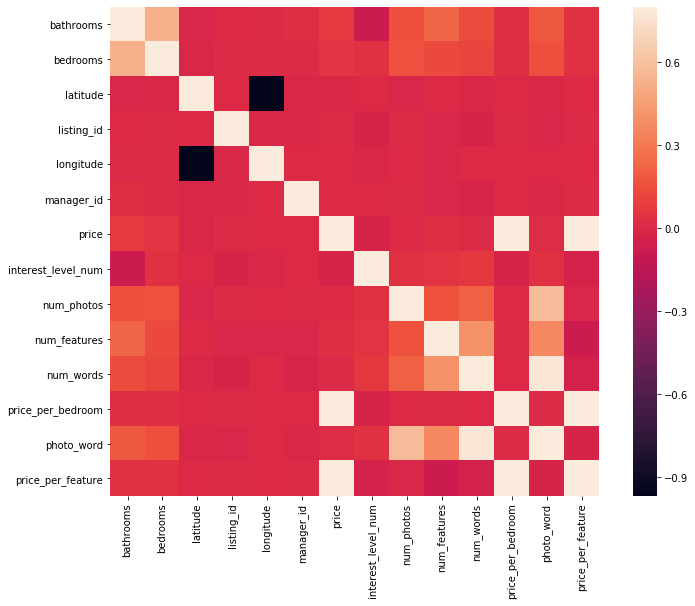

In [11]:
corrmat = df.corr()        # Finds correlation between all the columns
f, ax = plt.subplots(figsize=(12, 9))             # Increases the figure size to (12, 9)
sns.heatmap(corrmat, vmax = 0.8, square=True);

In [12]:
print("Features which most affects to interest level : \n")
related_cols = corrmat.nlargest(20, 'interest_level_num')
print(related_cols['interest_level_num'])

Features which most affects to interest level : 

interest_level_num    1.000000
num_words             0.066363
num_features          0.046334
photo_word            0.039237
bedrooms              0.036365
num_photos            0.034177
latitude              0.004821
manager_id            0.003740
longitude            -0.005184
price                -0.023681
price_per_bedroom    -0.026889
listing_id           -0.027698
price_per_feature    -0.032219
bathrooms            -0.079904
Name: interest_level_num, dtype: float64


In [13]:
y = df["interest_level"] 
features_to_use=['interest_level_num','manager_id',"bathrooms", "bedrooms", "latitude", "longitude", "price","num_photos", "num_features", "num_words","photo_word",'price_per_feature','price_per_bedroom']

In [14]:
X = df[features_to_use]

In [15]:
temp = pd.concat([X.manager_id,pd.get_dummies(y)], axis = 1).groupby('manager_id').mean()
temp.columns = ['high_interest_percent','low_interest_percent', 'medium_interest_percent']
temp['count'] = X.groupby('manager_id').count().iloc[:,1]
print(temp.head(5))

            high_interest_percent  low_interest_percent  \
manager_id                                                
0                             0.0              0.333333   
1                             0.0              1.000000   
2                             0.0              1.000000   
3                             0.0              0.000000   
4                             0.0              0.666667   

            medium_interest_percent  count  
manager_id                                  
0                          0.666667     12  
1                          0.000000     10  
2                          0.000000      1  
3                          1.000000      2  
4                          0.333333      3  


In [16]:
temp['manager_skill'] =  temp['high_interest_percent'] +  0.5 * temp['medium_interest_percent'] - temp['low_interest_percent']

In [17]:
print(temp.head(5))

            high_interest_percent  low_interest_percent  \
manager_id                                                
0                             0.0              0.333333   
1                             0.0              1.000000   
2                             0.0              1.000000   
3                             0.0              0.000000   
4                             0.0              0.666667   

            medium_interest_percent  count  manager_skill  
manager_id                                                 
0                          0.666667     12            0.0  
1                          0.000000     10           -1.0  
2                          0.000000      1           -1.0  
3                          1.000000      2            0.5  
4                          0.333333      3           -0.5  


In [18]:
X = X.merge(temp.reset_index(),how='left', left_on='manager_id', right_on='manager_id')
X.head()

,interest_level_num,manager_id,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_words,photo_word,price_per_feature,price_per_bedroom,high_interest_percent,low_interest_percent,medium_interest_percent,count,manager_skill
0,1,1568,1.5,3,40.7145,-73.9425,3000,5,0,95,475,0.0,1000.0,0.000000,0.744444,0.255556,90,-0.616667
1,0,1988,1.0,2,40.7947,-73.9667,5465,11,5,9,99,1093.0,2732.5,0.000000,0.988372,0.011628,86,-0.982558
2,1,3733,1.0,1,40.7388,-74.0018,2850,8,4,94,752,712.5,2850.0,0.059701,0.574627,0.365672,134,-0.332090
3,0,282,1.0,1,40.7539,-73.9677,3275,3,2,80,240,1637.5,3275.0,0.068063,0.806283,0.125654,191,-0.675393
4,0,2618,1.0,4,40.8241,-73.9493,3350,3,1,68,204,3350.0,837.5,0.000000,1.000000,0.000000,15,-1.000000


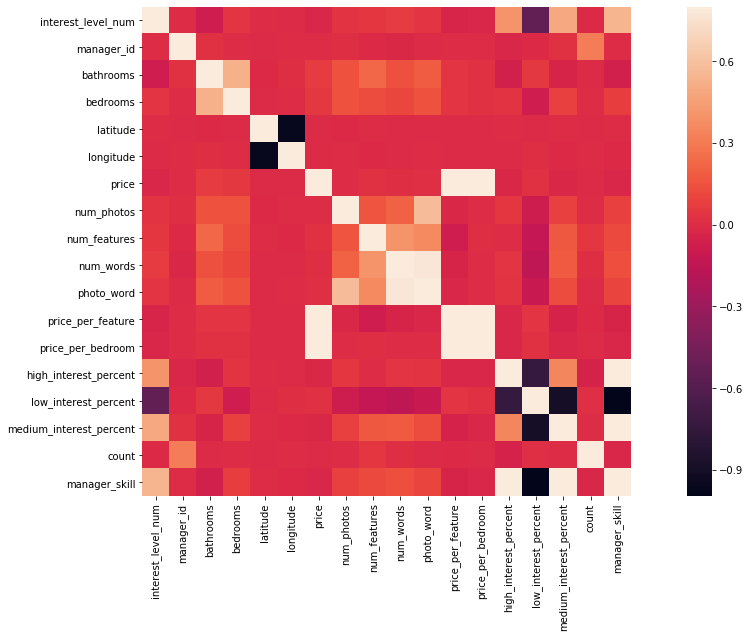

In [19]:
corrmat = X.corr()        # Finds correlation between all the columns
f, ax = plt.subplots(figsize=(20, 9))             # Increases the figure size to (12, 9)
sns.heatmap(corrmat, vmax = 0.8, square=True);

In [20]:
print("Features which most affects to interest level : \n")
related_cols = corrmat.nlargest(20, 'interest_level_num')
print(related_cols['interest_level_num'])

Features which most affects to interest level : 

interest_level_num         1.000000
manager_skill              0.542203
medium_interest_percent    0.485709
high_interest_percent      0.401216
num_words                  0.066363
num_features               0.046334
photo_word                 0.039237
bedrooms                   0.036365
num_photos                 0.034177
latitude                   0.004821
manager_id                 0.003740
longitude                 -0.005184
count                     -0.009493
price                     -0.023681
price_per_bedroom         -0.026889
price_per_feature         -0.032219
bathrooms                 -0.079904
low_interest_percent      -0.544771
Name: interest_level_num, dtype: float64


In [21]:
features_to_use=["bathrooms", "bedrooms", "latitude", "longitude", "price","num_photos", "num_features", "num_words","photo_word",'price_per_feature','price_per_bedroom', 'manager_skill']

In [22]:
X = X[features_to_use]

In [23]:
X.head(5)

,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_words,photo_word,price_per_feature,price_per_bedroom,manager_skill
0,1.5,3,40.7145,-73.9425,3000,5,0,95,475,0.0,1000.0,-0.616667
1,1.0,2,40.7947,-73.9667,5465,11,5,9,99,1093.0,2732.5,-0.982558
2,1.0,1,40.7388,-74.0018,2850,8,4,94,752,712.5,2850.0,-0.332090
3,1.0,1,40.7539,-73.9677,3275,3,2,80,240,1637.5,3275.0,-0.675393
4,1.0,4,40.8241,-73.9493,3350,3,1,68,204,3350.0,837.5,-1.000000


In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.30, random_state=0)

In [25]:
X.head(5)

,bathrooms,bedrooms,latitude,longitude,price,num_photos,num_features,num_words,photo_word,price_per_feature,price_per_bedroom,manager_skill
0,1.5,3,40.7145,-73.9425,3000,5,0,95,475,0.0,1000.0,-0.616667
1,1.0,2,40.7947,-73.9667,5465,11,5,9,99,1093.0,2732.5,-0.982558
2,1.0,1,40.7388,-74.0018,2850,8,4,94,752,712.5,2850.0,-0.332090
3,1.0,1,40.7539,-73.9677,3275,3,2,80,240,1637.5,3275.0,-0.675393
4,1.0,4,40.8241,-73.9493,3350,3,1,68,204,3350.0,837.5,-1.000000


In [26]:
clf = RandomForestClassifier(n_estimators=300)

In [27]:
clf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [28]:
y_prob = clf.predict_proba(X_test) 
log_loss(Y_test,y_prob)

0.578302846190771

In [29]:
clf.score(X_test, Y_test)

0.7513170336350128

# This is the part to generate output for kaggle

In [30]:
temp.head(4)

,high_interest_percent,low_interest_percent,medium_interest_percent,count,manager_skill
manager_id,,,,,
0,0.0,0.333333,0.666667,12,0.0
1,0.0,1.000000,0.000000,10,-1.0
2,0.0,1.000000,0.000000,1,-1.0
3,0.0,0.000000,1.000000,2,0.5


In [31]:
df_test = pd.read_json('./test.json')

In [32]:
describe_features_with_null_values(df_test)

,Null Count,Percentage


In [33]:
df_test["num_photos"] = df_test["photos"].apply(len)
df_test["num_features"] = df_test["features"].apply(len)
df_test["num_words"] = df_test["description"].apply(lambda x: len(x.split(" ")))
df_test["price_per_bedroom"] =df_test["price"]/df_test["bedrooms"]
df_test['photo_word'] = df_test['num_photos'] * df_test['num_words']
df_test['price_per_feature'] = df_test['price'] / df_test['num_features']
df_test['price_per_feature'] = df_test['price_per_feature'].replace(np.inf , 0)
df_test["price_per_bedroom"] = df_test['price_per_bedroom'].replace(np.inf , 0)

In [34]:
df_test.head(5)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,num_photos,num_features,num_words,price_per_bedroom,photo_word,price_per_feature
0,1.0,1,79780be1514f645d7e6be99a3de696c5,2016-06-11 05:29:41,Large with awesome terrace--accessible via bed...,Suffolk Street,"[Elevator, Laundry in Building, Laundry in Uni...",40.7185,7142618,-73.9865,b1b1852c416d78d7765d746cb1b8921f,[https://photos.renthop.com/2/7142618_1c45a2c8...,2950,99 Suffolk Street,8,6,78,2950.0,624,491.666667
1,1.0,2,0,2016-06-24 06:36:34,Prime Soho - between Bleecker and Houston - Ne...,Thompson Street,"[Pre-War, Dogs Allowed, Cats Allowed]",40.7278,7210040,-74.0000,d0b5648017832b2427eeb9956d966a14,[https://photos.renthop.com/2/7210040_d824cc71...,2850,176 Thompson Street,3,3,35,1425.0,105,950.000000
100,1.0,1,3dbbb69fd52e0d25131aa1cd459c87eb,2016-06-03 04:29:40,New York chic has reached a new level ...,101 East 10th Street,"[Doorman, Elevator, No Fee]",40.7306,7103890,-73.9890,9ca6f3baa475c37a3b3521a394d65467,[https://photos.renthop.com/2/7103890_85b33077...,3758,101 East 10th Street,6,3,333,3758.0,1998,1252.666667
1000,1.0,2,783d21d013a7e655bddc4ed0d461cc5e,2016-06-11 06:17:35,Step into this fantastic new Construction in t...,South Third Street\r,"[Roof Deck, Balcony, Elevator, Laundry in Buil...",40.7109,7143442,-73.9571,0b9d5db96db8472d7aeb67c67338c4d2,[https://photos.renthop.com/2/7143442_0879e9e0...,3300,251 South Third Street\r,6,10,204,1650.0,1224,330.000000
100000,2.0,2,6134e7c4dd1a98d9aee36623c9872b49,2016-04-12 05:24:17,"~Take a stroll in Central Park, enjoy the ente...","Midtown West, 8th Ave","[Common Outdoor Space, Cats Allowed, Dogs Allo...",40.7650,6860601,-73.9845,b5eda0eb31b042ce2124fd9e9fcfce2f,[https://photos.renthop.com/2/6860601_c96164d8...,4900,260 West 54th Street,7,14,174,2450.0,1218,350.000000


In [35]:
df_test['manager_id'] = lbl.transform(list(df_test['manager_id'].values))

In [36]:
df_test.describe()

,bathrooms,bedrooms,latitude,listing_id,longitude,manager_id,price,num_photos,num_features,num_words,price_per_bedroom,photo_word,price_per_feature
count,74659.000000,74659.000000,74659.000000,7.465900e+04,74659.000000,74659.000000,7.465900e+04,74659.000000,74659.000000,74659.000000,7.465900e+04,74659.000000,74659.000000
mean,1.212915,1.544663,40.735060,7.024001e+06,-73.945282,2254.239395,3.749033e+03,5.620193,5.423593,90.093050,1.943397e+03,552.857860,937.808315
std,0.649820,1.107014,0.806687,1.264496e+05,1.487795,1264.884083,9.713092e+03,3.641383,3.917167,60.771831,7.742781e+03,560.978663,2715.647803
min,0.000000,0.000000,0.000000,6.811958e+06,-121.488000,0.000000,1.000000e+00,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000
25%,1.000000,1.000000,40.727800,6.915516e+06,-73.991800,1142.000000,2.495000e+03,4.000000,2.000000,50.000000,1.100000e+03,204.000000,381.937500
50%,1.000000,1.000000,40.751600,7.021738e+06,-73.977700,2238.000000,3.150000e+03,5.000000,5.000000,83.000000,1.725000e+03,420.000000,647.375000
75%,1.000000,2.000000,40.774300,7.129166e+06,-73.954700,3438.000000,4.100000e+03,7.000000,8.000000,119.000000,2.700000e+03,738.000000,1120.000000
max,112.000000,7.000000,42.872700,7.761779e+06,0.000000,4398.000000,1.675000e+06,50.000000,36.000000,2837.000000,1.070000e+06,21590.000000,418750.000000


In [37]:
df_joined = df_test.join(other = temp , on = 'manager_id', how = 'left')

In [38]:
describe_features_with_null_values(df_joined)

,Null Count,Percentage
manager_skill,1474,1.97
count,1474,1.97
medium_interest_percent,1474,1.97
low_interest_percent,1474,1.97
high_interest_percent,1474,1.97


In [39]:
df_joined['low_interest_percent'].replace(np.NaN , 0.7 , True)
df_joined['medium_interest_percent'].replace(np.NaN , 0.2 , True)
df_joined['high_interest_percent'].replace(np.NaN , 0.1, True)

In [40]:
features_to_use=["bathrooms", "bedrooms", "latitude", "longitude", "price","num_photos", "num_features", "num_words","photo_word",'price_per_feature','price_per_bedroom' , 'manager_skill']

In [41]:
describe_features_with_null_values(df_joined)

,Null Count,Percentage
manager_skill,1474,1.97
count,1474,1.97


In [42]:
df_joined['manager_skill'] =  df_joined['high_interest_percent'] +0.5* df_joined['medium_interest_percent'] - df_joined['low_interest_percent']

In [43]:
test_prob = clf.predict_proba(df_joined[features_to_use])

In [44]:

high = []
low = []
med = []

In [45]:
listing_id = df_joined.listing_id

In [46]:
for pred in test_prob:
    high.append( pred[0])
    low.append (pred[1])
    med.append( pred[2])

In [47]:
sub = pd.DataFrame({'listing_id':listing_id , 'high':high,'medium':med,'low':low}).reset_index()

In [48]:
sub = sub.drop('index' ,axis = 1)

In [49]:
sub.head(5)

,listing_id,high,medium,low
0,7142618,0.191333,0.540611,0.268056
1,7210040,0.016667,0.020000,0.963333
2,7103890,0.033333,0.606198,0.360468
3,7143442,0.214611,0.448444,0.336944
4,6860601,0.020000,0.245000,0.735000


In [50]:
sub.to_csv('./submission.csv' , index = False)